## Importing the required libraries

In [2]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [3]:
from keras import regularizers

In [4]:
import os

## Filename identifiers 

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

In [5]:
mylist= os.listdir('RawData/')

In [6]:
type(mylist)

list

In [7]:
print(mylist[1400])

03-01-04-02-01-01-13.wav


In [8]:
print(mylist[1400][6:-16])

04


## Plotting the audio file's waveform and its spectrogram

In [9]:
data, sampling_rate = librosa.load('RawData/03-01-03-01-01-01-16.wav', sr=None)

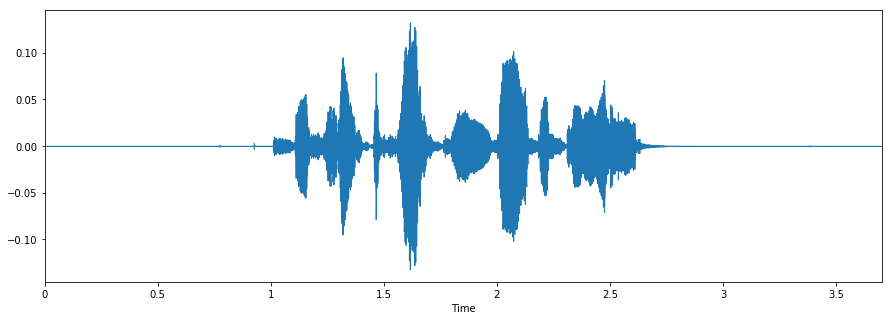

In [10]:
#% pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

/home/absin/Documents/dev/py3env/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
/home/absin/Documents/dev/py3env/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log


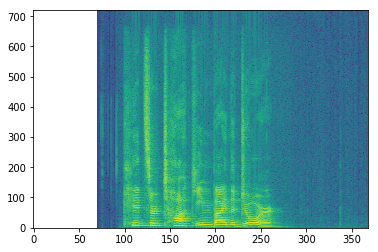

In [11]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys


sr,x = scipy.io.wavfile.read('RawData/03-01-03-01-01-01-16.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

## Setting the labels

In [12]:
feeling_list=[]
for item in mylist:
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')
    elif item[:1]=='a':
        feeling_list.append('male_angry')
    elif item[:1]=='f':
        feeling_list.append('male_fearful')
    elif item[:1]=='h':
        feeling_list.append('male_happy')
    #elif item[:1]=='n':
        #feeling_list.append('neutral')
    elif item[:2]=='sa':
        feeling_list.append('male_sad')

In [13]:
labels = pd.DataFrame(feeling_list)

In [14]:
labels[:10]

,0
0,female_calm
1,male_fearful
2,female_sad
3,male_happy
4,female_angry
5,male_calm
6,male_fearful
7,male_sad
8,female_sad
9,female_happy


## Getting the features of audio files using librosa

In [16]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
        X, sample_rate = librosa.load('RawData/'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=13),
                        axis=0)
        feature = mfccs
        #[float(i) for i in feature]
        #feature1=feature[:135]
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1        

In [17]:
df[:5]

,feature
0,"[-68.85481467869607, -68.85481467869607, -68.8..."
1,"[-45.59396978256373, -45.28888738284796, -43.9..."
2,"[-54.541561714624514, -52.65220555445233, -52...."
3,"[-42.21743442006511, -40.56047933910907, -40.2..."
4,"[-45.123066399925555, -45.123066399925555, -45..."


In [18]:
df3 = pd.DataFrame(df['feature'].values.tolist())

df3[:5]

In [19]:
newdf = pd.concat([df3,labels], axis=1)

In [20]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [21]:
rnewdf[:5]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
0,-68.854815,-68.854815,-68.854815,-68.854815,-68.854815,-68.854815,-68.854815,-68.854815,-68.854815,-68.854815,...,-68.792789,-68.723161,-68.000214,-66.457189,-68.129666,-68.811113,-67.433522,-67.296229,-68.486082,female_calm
1,-45.593970,-45.288887,-43.909746,-43.639006,-44.616296,-43.998122,-43.588965,-44.078374,-43.900877,-42.735786,...,-40.460424,-40.520291,-40.441986,-41.478265,-42.777435,-41.823463,-41.062489,-40.644083,-42.000237,male_fearful
2,-54.541562,-52.652206,-52.555295,-53.107349,-53.001784,-52.325148,-51.463902,-53.362503,-53.288201,-54.680249,...,-54.983267,-55.473413,-54.866709,-58.022633,-57.014260,-52.991421,-52.545435,-53.893303,-55.545372,female_sad
3,-42.217434,-40.560479,-40.231336,-41.971320,-41.413196,-41.679765,-40.859462,-40.977621,-41.878338,-42.805991,...,-31.011208,-31.791346,-34.396537,-34.452414,-34.094194,-35.161084,-35.943979,-37.234014,-38.118160,male_happy
4,-45.123066,-45.123066,-45.123066,-45.123066,-45.123066,-45.123066,-45.123066,-45.123066,-45.123066,-45.123066,...,-29.173194,-29.597275,-29.886308,-30.992017,-30.784470,-30.693968,-32.584357,-32.333907,-28.859692,female_angry


In [22]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
471,-72.856524,-71.332147,-75.139429,-71.882510,-68.121865,-67.206614,-68.452237,-74.387108,-76.455479,-68.271610,...,-36.053599,-36.704734,-36.218905,-38.324239,-42.703020,-43.447927,-42.426511,-46.249590,-46.938643,male_calm
209,-53.973089,-54.414271,-54.019228,-53.768910,-54.355623,-56.858708,-59.874911,-61.195373,-62.126527,-59.115341,...,-59.767191,-58.772052,-56.262722,-58.589130,-57.304635,-55.471342,-56.585218,-54.511202,-54.561819,male_calm
616,-54.455935,-53.982046,-54.226074,-54.517805,-54.183947,-53.555767,-53.997486,-53.495771,-53.639700,-52.096820,...,-49.106188,-49.732930,-55.100580,-60.151305,-57.252515,-55.847716,-56.277506,-57.325377,-56.124289,male_calm
479,-45.739615,-40.491761,-37.945276,-36.681511,-35.135588,-34.828884,-36.005736,-36.209401,-35.726750,-36.520796,...,-60.030684,-58.279354,-57.488321,-57.152054,-60.502762,-67.557878,-61.624913,-58.158140,-54.761308,male_calm
245,-54.660431,-54.801125,-54.174855,-56.207017,-52.512182,-53.809550,-54.603161,-55.583662,-54.093210,-53.048021,...,-52.305698,-54.098838,-55.128152,-60.419146,-55.361616,-53.379672,-55.778797,-61.106613,-61.522123,female_sad
791,-56.621165,-55.743969,-54.492014,-53.670320,-54.301261,-56.621165,-55.586514,-55.458795,-55.311822,-54.696216,...,-32.287405,-32.216282,-32.553245,-33.750728,-35.036890,-34.989976,-35.287886,-37.657556,-40.861137,male_angry
174,-57.527229,-56.894404,-56.256938,-57.379610,-58.494613,-58.286768,-57.229652,-55.460912,-54.526665,-54.932347,...,-34.065218,-36.609731,-36.969910,-35.973237,-36.665770,-36.539289,-35.480984,-36.593061,-37.479826,male_angry
274,-41.046704,-41.270149,-40.987186,-41.231461,-42.389352,-43.125082,-43.653063,-44.034445,-43.265570,-42.933963,...,-14.641793,-14.740010,-15.978467,-15.482116,-16.631014,-17.280855,-18.545255,-19.250503,-21.389457,male_angry
113,-50.062887,-47.360695,-46.925770,-48.825139,-50.617722,-48.990637,-48.279949,-49.367253,-48.450745,-47.929100,...,-46.818363,-46.326427,-45.161317,-47.336030,-48.390788,-48.770046,-49.709867,-48.147668,-50.306879,female_calm
803,-64.534291,-64.325076,-63.853970,-64.193312,-63.725819,-63.490842,-63.156243,-63.427652,-62.722235,-61.840598,...,-54.486860,-54.230501,-53.384236,-53.845538,-54.256861,-52.946319,-53.507972,-52.474002,-51.640947,male_fearful


In [23]:
rnewdf=rnewdf.fillna(0)

## Dividing the data into test and train

In [24]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [25]:
train[250:260]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
119,-51.304312,-51.096630,-52.201351,-49.012963,-48.303825,-49.131107,-50.838593,-51.587054,-51.444771,-51.174815,...,-46.198147,-47.134585,-47.472096,-48.502917,-50.286425,-49.676973,-47.545616,-46.131727,-45.345736,female_happy
779,-54.071434,-53.270441,-55.962005,-55.425948,-56.699237,-55.350538,-52.082626,-53.349495,-54.608616,-54.911032,...,-53.482203,-53.487210,-52.997875,-52.097820,-49.879058,-51.867677,-51.888519,-52.556569,-52.861004,male_angry
367,-51.869047,-52.172500,-52.459898,-52.298734,-51.766712,-51.786517,-51.769278,-51.823124,-51.851056,-51.879569,...,-36.051604,-36.980185,-38.139247,-35.880857,-34.956066,-36.184118,-34.353503,-23.236961,-16.939166,female_angry
871,-57.756826,-56.945218,-55.402335,-54.326853,-54.621980,-55.201250,-57.895613,-57.895613,-56.603973,-56.500033,...,-29.067356,-28.063373,-26.223268,-27.358451,-30.899799,-33.100692,-33.505974,-35.205846,-35.774270,male_happy
109,-52.144882,-53.959018,-55.145461,-53.612339,-52.147070,-49.463857,-49.172999,-52.111884,-53.611675,-50.524048,...,-50.998890,-52.317006,-51.349279,-51.088707,-51.130629,-50.069041,-50.267326,-51.520944,-52.932136,female_sad
390,-69.051400,-69.051400,-69.051400,-69.051400,-69.051400,-68.754863,-69.051400,-69.051400,-69.051400,-68.359101,...,-57.681647,-56.301264,-58.650128,-63.881082,-63.749409,-65.222466,-65.308242,-67.008563,-68.636299,male_calm
647,-49.403984,-49.756542,-50.077997,-49.911071,-50.008593,-50.078172,-49.785094,-49.236030,-49.006328,-47.116429,...,-38.080414,-41.300520,-42.007527,-40.983115,-43.161027,-45.158194,-44.344350,-44.234428,-43.283844,female_sad
519,-55.349543,-55.585305,-56.931356,-56.681721,-56.784476,-55.854030,-55.723222,-56.154396,-55.498716,-53.932386,...,-57.985374,-58.166031,-58.036148,-55.960418,-56.344690,-57.951899,-54.570671,-51.357930,-52.141321,female_fearful
553,-56.274256,-55.831278,-55.714721,-53.284979,-54.062137,-55.381593,-56.324931,-54.312253,-54.464139,-55.783244,...,-54.917200,-58.299194,-55.334668,-52.632266,-53.408024,-54.989300,-52.086280,-52.188606,-52.147362,female_calm
442,-64.311404,-58.837348,-57.070674,-59.403286,-59.159440,-56.119573,-56.304894,-62.215263,-62.511671,-64.500209,...,-60.223600,-57.189248,-57.962821,-60.110766,-58.582106,-56.410975,-56.471134,-58.010376,-59.470420,male_fearful


In [26]:
trainfeatures = train.iloc[:, :-1]

In [29]:
trainlabel = train.iloc[:, -1:]
trainlabel

,0
471,male_calm
616,male_calm
245,female_sad
791,male_angry
174,male_angry
113,female_calm
803,male_fearful
585,male_sad
515,male_happy
476,female_sad


In [30]:
testfeatures = test.iloc[:, :-1]

In [31]:
testlabel = test.iloc[:, -1:]
testlabel

,0
209,male_calm
479,male_calm
274,male_angry
700,female_fearful
922,female_calm
895,female_calm
942,male_calm
418,female_fearful
190,male_sad
711,male_happy


In [32]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))


/home/absin/Documents/dev/py3env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [34]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [35]:
X_train.shape

(763, 216)

## Changing dimension for CNN model

In [31]:

x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [45]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

In [46]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 216, 256)          1536      
_________________________________________________________________
activation_11 (Activation)   (None, 216, 256)          0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 216, 128)          163968    
_________________________________________________________________
activation_12 (Activation)   (None, 216, 128)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 216, 128)          0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 27, 128)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 27, 128)           82048     
__________

In [47]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

### Removed the whole training part for avoiding unnecessary long epochs list

In [ ]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=700, validation_data=(x_testcnn, y_test))

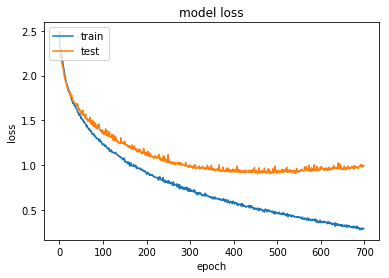

In [37]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model

In [112]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:\Users\mites\Documents\Cognitive\Final Exam\saved_models\Emotion_Voice_Detection_Model.h5 


In [133]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [137]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
acc: 72.73%


## Predicting emotions on the test data

In [138]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

319/319 [==============================] - 0s     


In [139]:
preds

array([[  3.49815641e-12,   1.18043589e-10,   1.13181663e-19, ...,
          1.80016723e-05,   7.36836637e-06,   1.14132257e-04],
       [  3.87504338e-16,   5.73074694e-23,   1.31673211e-14, ...,
          1.75147681e-04,   1.85760673e-05,   9.99805748e-01],
       [  8.39285008e-07,   3.43896300e-11,   5.38965035e-03, ...,
          9.93317604e-01,   1.99900052e-04,   1.05243188e-03],
       ..., 
       [  3.49616457e-04,   1.94651744e-04,   6.65218568e-06, ...,
          1.67340226e-02,   6.44345134e-02,   9.10043001e-01],
       [  4.23396705e-06,   1.59581254e-11,   6.03030126e-12, ...,
          6.36715861e-03,   9.64888096e-01,   2.34207995e-02],
       [  3.69524572e-31,   0.00000000e+00,   0.00000000e+00, ...,
          5.24333927e-07,   9.99998808e-01,   6.36476927e-10]], dtype=float32)

In [115]:
preds1=preds.argmax(axis=1)

In [116]:
preds1

array([6, 9, 7, 1, 7, 8, 1, 2, 5, 8, 7, 1, 9, 9, 4, 0, 5, 0, 5, 8, 4, 1, 5,
       9, 7, 5, 7, 1, 7, 5, 8, 1, 8, 9, 2, 2, 1, 8, 6, 0, 5, 9, 1, 0, 7, 5,
       5, 7, 7, 0, 0, 7, 0, 0, 6, 5, 3, 7, 5, 8, 5, 4, 8, 8, 9, 7, 2, 8, 6,
       1, 5, 6, 8, 6, 5, 3, 4, 8, 8, 9, 9, 0, 8, 9, 4, 5, 0, 0, 5, 5, 7, 9,
       4, 7, 8, 6, 9, 5, 6, 8, 1, 7, 0, 8, 8, 7, 3, 2, 7, 8, 7, 9, 7, 9, 5,
       7, 8, 6, 0, 1, 6, 9, 1, 5, 8, 7, 1, 8, 6, 9, 3, 7, 7, 4, 6, 5, 8, 8,
       1, 0, 5, 0, 7, 6, 5, 7, 4, 9, 2, 5, 4, 7, 5, 6, 8, 5, 5, 4, 8, 8, 2,
       7, 5, 7, 6, 9, 8, 9, 9, 0, 2, 5, 7, 8, 3, 0, 4, 6, 6, 9, 9, 9, 3, 8,
       1, 7, 2, 5, 8, 1, 8, 4, 4, 8, 5, 2, 9, 9, 5, 6, 0, 5, 9, 0, 8, 7, 4,
       6, 6, 3, 9, 5, 9, 6, 1, 7, 5, 7, 8, 4, 9, 2, 5, 6, 6, 4, 2, 1, 8, 2,
       7, 5, 7, 3, 5, 6, 8, 7, 1, 6, 0, 0, 4, 7, 4, 4, 4, 4, 4, 0, 8, 1, 6,
       7, 4, 8, 7, 8, 2, 9, 6, 2, 7, 8, 3, 9, 9, 7, 2, 5, 7, 2, 9, 5, 5, 7,
       8, 5, 6, 8, 1, 2, 5, 9, 4, 5, 5, 6, 7, 8, 7, 0, 9, 5, 9, 5, 9, 7, 8,
       1, 2,

In [117]:
abc = preds1.astype(int).flatten()

In [118]:
predictions = (lb.inverse_transform((abc)))

In [119]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,male_calm
1,male_sad
2,male_fearful
3,female_calm
4,male_fearful
5,male_happy
6,female_calm
7,female_fearful
8,male_angry
9,male_happy


In [120]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [121]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,male_calm
1,male_sad
2,male_fearful
3,female_fearful
4,male_fearful
5,male_happy
6,female_calm
7,female_angry
8,male_angry
9,male_happy


In [122]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [128]:
finaldf[170:180]

,actualvalues,predictedvalues
170,female_fearful,female_fearful
171,male_angry,male_angry
172,male_fearful,male_fearful
173,male_happy,male_happy
174,female_happy,female_happy
175,female_angry,female_angry
176,female_angry,female_sad
177,male_sad,male_calm
178,male_angry,male_calm
179,male_sad,male_sad


In [129]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,21
female_calm,20
female_fearful,19
female_happy,17
female_sad,20
male_angry,55
male_calm,25
male_fearful,55
male_happy,49


In [130]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,25
female_calm,22
female_fearful,19
female_happy,9
female_sad,25
male_angry,51
male_calm,29
male_fearful,51
male_happy,50


In [131]:
finaldf.to_csv('Predictions.csv', index=False)

## Live Demo

#### The file 'output10.wav' in the next cell is the file that was recorded live using the code in AudioRecoreder notebook found in the repository

In [485]:
data, sampling_rate = librosa.load('output10.wav')

Populating the interactive namespace from numpy and matplotlib


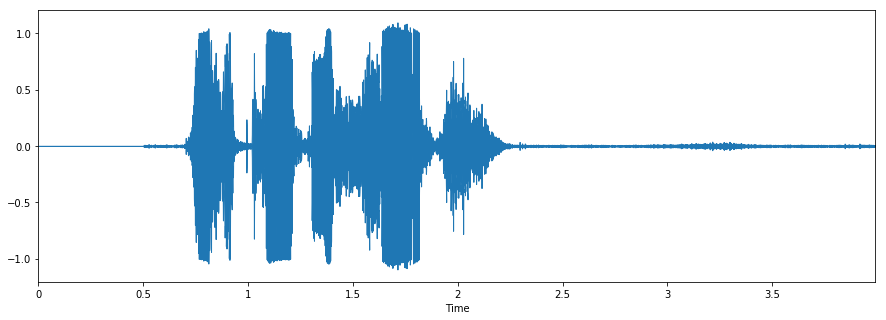

In [486]:
% pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [487]:
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load('output10.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [488]:
livedf2= pd.DataFrame(data=livedf2)

In [489]:
livedf2 = livedf2.stack().to_frame().T

In [490]:
livedf2

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-18.203564,-21.471836,-22.52221,-21.712259,-22.264288,-20.707904,-21.726444,-21.76865,-24.302736,-22.250634,...,-24.273819,-24.639939,-24.929152,-24.43919,-25.210171,-24.740646,-22.311913,-22.579805,-22.31466,-21.552436


In [491]:
twodim= np.expand_dims(livedf2, axis=2)

In [492]:
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 0s


In [493]:
livepreds

array([[  9.24052530e-22,   0.00000000e+00,   3.62402176e-26,
          1.30680162e-36,   4.47264152e-28,   1.00000000e+00,
          1.80208343e-30,   2.76873961e-27,   3.62227194e-23,
          1.67396652e-11]], dtype=float32)

In [494]:
livepreds1=livepreds.argmax(axis=1)

In [495]:
liveabc = livepreds1.astype(int).flatten()

In [496]:
livepredictions = (lb.inverse_transform((liveabc)))
livepredictions

array(['male_angry'], dtype=object)